# PyTorch Hybrid Quantum Convolution Neural Network chest X-ray for cardiac diagnosis

## final results

In [1]:
import numpy as np
import pandas as pd
from seaborn import heatmap
import matplotlib.pyplot as plt

import random
import os
import copy

In [2]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [3]:
def plot_ROC(name,y_true, y_score):

    # ROC Curve and AUROC
    plt.figure(0).clf()
    if np.sum(y_true) != 0.:        
        fpr, tpr, _ = metrics.roc_curve(y_true, y_score)
        auc = round(metrics.roc_auc_score(y_true, y_score), 4)
        plt.plot(fpr,tpr,label=name + ", AUC =" + str(auc))
    plt.legend();

In [4]:
def conf_matrix(model, y, y_pred):
    fig, ax =plt.subplots(figsize=(3.5,3.5))
    labels=['No','Yes']
    ax=heatmap(confusion_matrix(y, y_pred), annot=True, cmap="Blues", fmt='g', cbar=False, annot_kws={"size":25})
    plt.title(model) #, fontsize=20)
    ax.xaxis.set_ticklabels(labels, fontsize=17) 
    ax.yaxis.set_ticklabels(labels, fontsize=17)
    ax.set_ylabel('Test')
    ax.set_xlabel('Predicted')

In [5]:
def plot_multi_ROC_model(name, model_dic):
        
    #suptitle = "ROC curve for "+str(len(feature_list))+"-feature dataset"
    #title = "\n(Positive Label: Coronary Artery Disease - Random State:"\
            #+ str(random_state) +')'
    
    plt.figure(0).clf()    
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
    ax = plt.gca()
    ax.set_aspect('equal', adjustable='box')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.plot([0,1], [0,1], 'k--')
    #plt.suptitle(suptitle)
    plt.title(name, fontsize = 10)
    
    for curve_name, df in model_dic.items():
        #s#vc_output , sample_test, y_true = support_vector_machine(data, feature_list, y_score,
                                                                  #random_state = random_state)
        #y_pred = svc_output.predict(sample_test)
        #y_score = svc_output.decision_function(sample_test)
        y_true = df.label
        y_score = df.prob
        fpr, tpr, _ = roc_curve(y_true, y_score)
        auc = roc_auc_score(y_true, y_score)
        plt.plot(fpr,tpr,
                 label= curve_name+" - AUC = %0.4f" % auc)
    plt.legend(fontsize = 'small')    
    if save_result and name: plt.savefig(f"{result_OUT}/{name}_roc.png")
    if save_result and name==None: plt.savefig(f"{result_OUT}/ALL_roc.png")
    plt.show()
    return

def PRF_graph(name, model_dic):
    auc_list = []
    acc_list = []
    p0_list = []
    r0_list = []
    f0_list = []
    p1_list = []
    r1_list = []
    f1_list = []
    index_m =[]
    for model, df in model_dic.items():
        auc_m = roc_auc_score(df.label, df.prob)
        acc_m = accuracy_score(df.label, df.pred)
        precision, recall, fscore, _ = precision_recall_fscore_support(df.label, df.pred)
        auc_list.append(auc_m)
        acc_list.append(acc_m)
        p0_list.append(precision[0])
        r0_list.append(recall[0])
        f0_list.append(fscore[0])
        p1_list.append(precision[1])
        r1_list.append(recall[1])
        f1_list.append(fscore[1])
        index_m.append(model)   
    pd.set_option('display.precision', 3)
    df_m = pd.DataFrame(auc_list, index = index_m, columns = ['AUC Score'])
    df_m['Accuracy'] = acc_list
    df_m['Precision 0'] = p0_list
    df_m['Precision 1'] = p1_list
    df_m['Recall 0'] = r0_list
    df_m['Recall 1'] = r1_list
    df_m['F1 Score 0'] = f0_list
    df_m['F1 score 1'] = f1_list
    df_m = df_m.style.highlight_max(color = 'yellow', axis = 0)
    if save_result: df_m.to_excel(f"{result_OUT}/PRF.xlsx")
    return df_m

def plt_loss(name,model_dic):
    #plt.rcParams["figure.figsize"] = (5.5, 4)
    plt.figure(0).clf()
    plt.title("Training loss against Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Training loss")
    plt.title(name, fontsize = 10)
    for curve_name, test_loss in model_dic.items():
        sd = []
        av = []
        try:
            shape = 18
            loss_list = np.array(test_loss).flatten().reshape(shape,214)
        except:
            shape = 20
            loss_list = np.array(test_loss).flatten().reshape(shape,214)
        for i in range(1,shape+1):
            #print(loss_list[:,:i].shape)
            sd.append(np.std(loss_list[:i]))
            av.append(np.average(loss_list[:i]))
        plt.plot(range(shape), av, label=curve_name)
        plt.fill_between(range(shape), av+np.array(sd), av-np.array(sd), alpha=0.1)
    plt.legend(fontsize = 'small')
    if save_result and name: plt.savefig(f"{result_OUT}/{name}_loss.png")
    if save_result and name==None: plt.savefig(f"{result_OUT}/ALL_loss.png")
    plt.show()

def change_dic_name(dic,old, new):
    pos = list(dic).index(old)
    key = new
    value = dic[old]
    del dic[old]
    dic = list(dic.items())
    dic.insert(pos,(key,value))
    return dict(dic)

def get_variable_name(variable):
    globals_dict = globals()
    return [var_name for var_name in globals_dict if globals_dict[var_name] is variable]

In [6]:
import re
import time
save_result=True

s_dir = "image_result/"

if save_result:
    # create folder and save the result
    time_str = time.strftime("%Y%m%d-%H%M%S")
    result_OUT = f"image_result/result_{time_str}"
    os.makedirs(result_OUT, exist_ok=True)

f = open("result.txt", "r")
d_dir = f.read().splitlines()
f.close()
print(d_dir)

m_list = ["F","F","F","F","F"  ,"N","N","N","N","N"  ,"F_6q","F_8q","F_10q"]

csv_list = ["y_probbs_densenet121_model", 
            "y_probbs_alexnet_model",
            "y_probbs_PL_qnn_model",
           "y_probbs_Qiskit_easy_2_qnn_model",
           "y_probbs_Qiskit_easy_4_qnn_model"]
name_list= ["D","A","P","Q2","Q4"]

#densenet, alexnet, pennylane, qiskit
all_val_model_dic = {}
all_train_model_dic = {}
all_loss_dic = {}

for d,i in enumerate(d_dir):
    for n,j in enumerate(csv_list):
        try:
            # extract model name
            model = f"{m_list[d]}_" + re.search(r'y_probbs_(.*?)_model', j).group(1)
            csv_file = re.search(r'y_probbs_(.*?)_model', j).group(1) + "_model_train_loss.csv"
            #print(s_dir+f'{i}/{csv_file}')
            
            exec(f"loss_{m_list[d]}C{name_list[n]} = pd.read_csv(s_dir+f'{i}/{csv_file}',header=None)")
            loss = eval(f"loss_{m_list[d]}C{name_list[n]}")
            all_loss_dic[model] = loss
            for t in ['val', 'train']:
                #print(f"{i}/{j}_{t}.csv'")
                exec(f"df_{t}{m_list[d]}C{name_list[n]} = pd.read_csv(s_dir+'{i}/{j}_{t}.csv')")
                df = eval(f"df_{t}{m_list[d]}C{name_list[n]}")
                exec(f"all_{t}_model_dic[model] = df")
        except:
            pass
        else:
            #printing
            print(f"df_val{m_list[d]}C{name_list[n]}, {j}, {model}")
            #report = classification_report(df.label,
            #                            df.pred,
            #                            digits = 3, output_dict=save_result)
            #if save_result: 
            #    pd.DataFrame(report).transpose().to_csv(f"{result_OUT}/{model}_CLR.csv",index=False)
            #else:
            #    print(report)
            
            #conf_matrix(model, df.label, df.pred)
            #if save_result: plt.savefig(f"{result_OUT}/{model}_conf.png")
            #plt.close()
    print()

#change name if you need
for d_list in [all_val_model_dic,all_train_model_dic, all_loss_dic]:
    d_name = get_variable_name(d_list)[0]
    exec(f"{d_name} = change_dic_name({d_name}, 'F_densenet121', 'F-Dnet-C')")
    exec(f"{d_name} = change_dic_name({d_name}, 'F_alexnet', 'F-Axnet-C')")
    exec(f"{d_name} = change_dic_name({d_name}, 'F_PL_qnn', 'F-Dnet-P-4q')")
    exec(f"{d_name} = change_dic_name({d_name}, 'F_Qiskit_easy_2_qnn', 'F-Dnet-Q-4q-2D')")
    exec(f"{d_name} = change_dic_name({d_name}, 'F_Qiskit_easy_4_qnn', 'F-Dnet-Q-4q-4D')")
    
    exec(f"{d_name} = change_dic_name({d_name}, 'N_densenet121', 'N-Dnet-C')")
    exec(f"{d_name} = change_dic_name({d_name}, 'N_alexnet', 'N-Axnet-C')")
    exec(f"{d_name} = change_dic_name({d_name}, 'N_PL_qnn', 'N-Dnet-P-4q')")
    exec(f"{d_name} = change_dic_name({d_name}, 'N_Qiskit_easy_2_qnn', 'N-Dnet-Q-4q-2D')")
    exec(f"{d_name} = change_dic_name({d_name}, 'N_Qiskit_easy_4_qnn', 'N-Dnet-Q-4q-4D')")
    
    exec(f"{d_name} = change_dic_name({d_name}, 'F_6q_PL_qnn', 'F-Dnet-P-6q')")
    exec(f"{d_name} = change_dic_name({d_name}, 'F_8q_PL_qnn', 'F-Dnet-P-8q')")
    exec(f"{d_name} = change_dic_name({d_name}, 'F_10q_PL_qnn', 'F-Dnet-P-10q')")

['densenet121_model_2_20230410-175100', 'alexnet_model_2_20230410-180221', 'PL_qnn_model_2_20230410-180432', 'Qiskit_easy_2_qnn_model_2_20230410-184347', 'Qiskit_easy_4_qnn_model_2_20230410-221830', 'densenet121_model_0_20230410-060951', 'alexnet_model_0_20230410-063143', 'PL_qnn_model_0_20230410-063432', 'Qiskit_easy_2_qnn_model_0_20230410-073647', 'Qiskit_easy_4_qnn_model_0_20230410-155349', 'PL_qnn_model_2_20230410-105754', 'PL_qnn_model_2_20230410-114707', 'PL_qnn_model_2_20230410-143050']
df_valFCD, y_probbs_densenet121_model, F_densenet121

df_valFCA, y_probbs_alexnet_model, F_alexnet

df_valFCP, y_probbs_PL_qnn_model, F_PL_qnn

df_valFCQ2, y_probbs_Qiskit_easy_2_qnn_model, F_Qiskit_easy_2_qnn

df_valFCQ4, y_probbs_Qiskit_easy_4_qnn_model, F_Qiskit_easy_4_qnn

df_valNCD, y_probbs_densenet121_model, N_densenet121

df_valNCA, y_probbs_alexnet_model, N_alexnet

df_valNCP, y_probbs_PL_qnn_model, N_PL_qnn

df_valNCQ2, y_probbs_Qiskit_easy_2_qnn_model, N_Qiskit_easy_2_qnn

df_valNCQ4, 

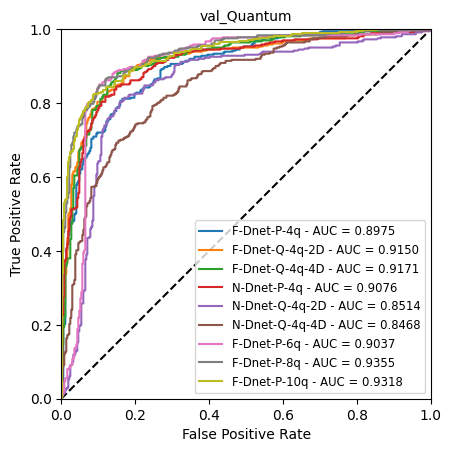

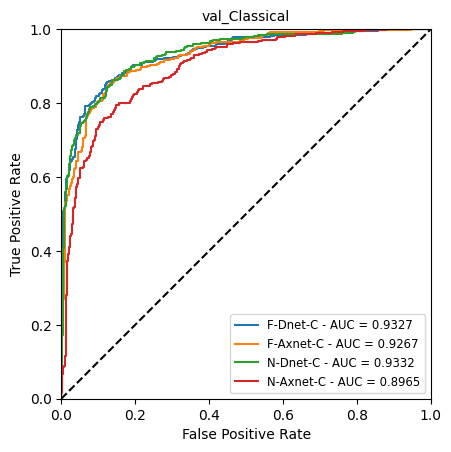

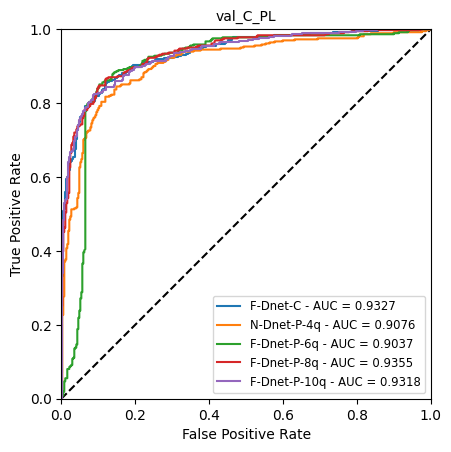

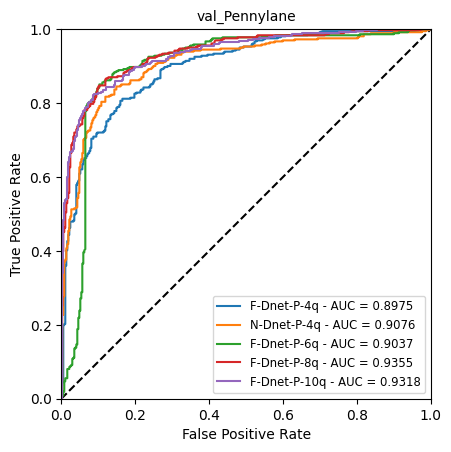

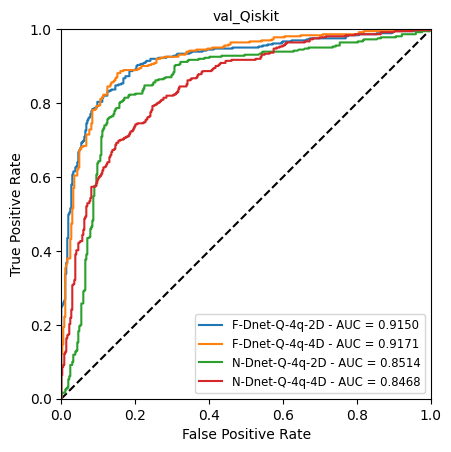

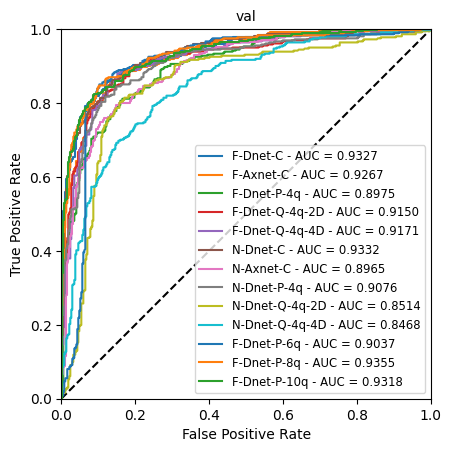

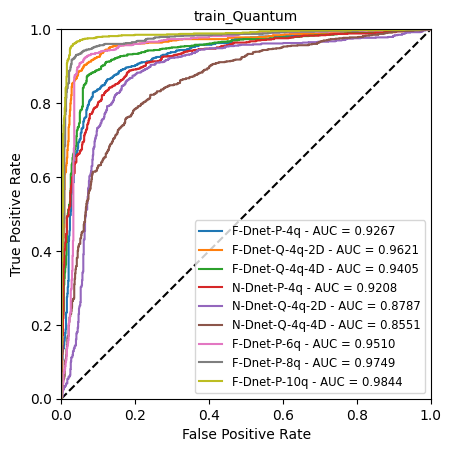

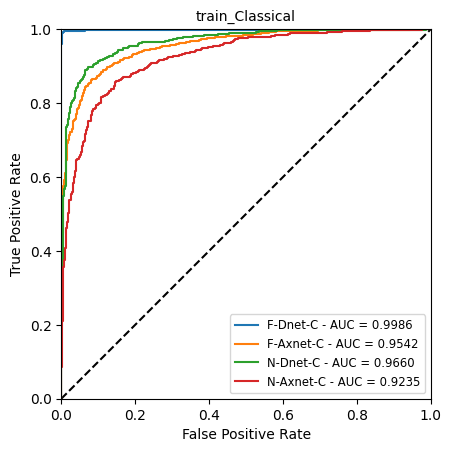

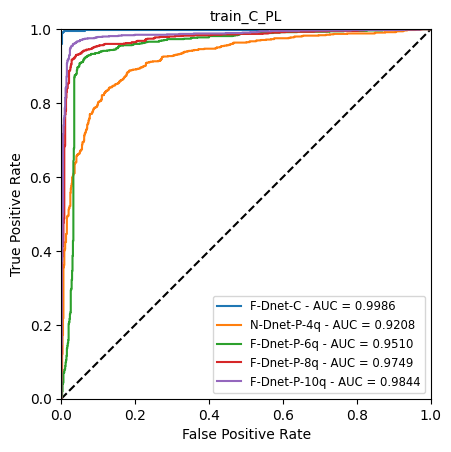

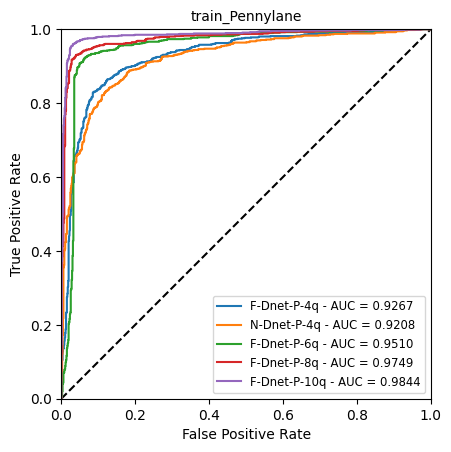

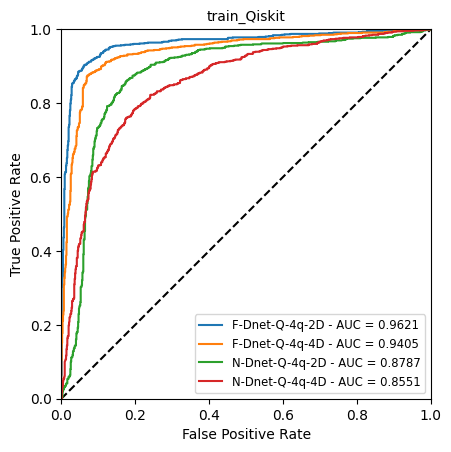

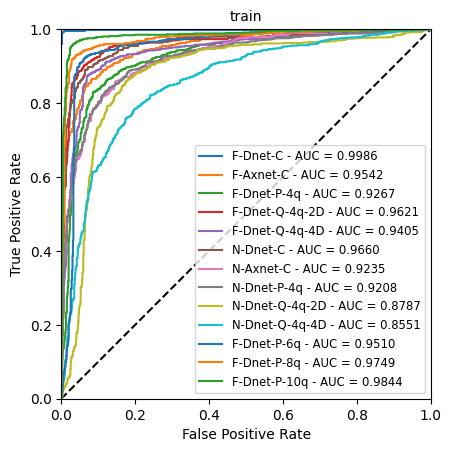

In [7]:
for t_dict in ["val", "train"]:
    ROC_dic = {
    f"{t_dict}_Quantum" : [2,3,4,7,8,9,10,11,12], 
    f"{t_dict}_Classical" : [0,1,5,6],
    f"{t_dict}_C_PL" : [0,7,10,11,12],
    f"{t_dict}_Pennylane" : [2,7,10,11,12],
    f"{t_dict}_Qiskit" : [3,4,8,9],
    }
    for name,seq in ROC_dic.items():
        ROC_dic_graph = {}
        for num,(nm, df) in enumerate(eval(f"all_{t_dict}_model_dic").items()):
            if num in seq:
                ROC_dic_graph[nm] = df
        plot_multi_ROC_model(name, ROC_dic_graph)
    
    # sort the dictionary if you want
    plot_multi_ROC_model(t_dict, eval(f"all_{t_dict}_model_dic"))

In [10]:
PRF_graph(None,all_val_model_dic)

,AUC Score,Accuracy,Precision 0,Precision 1,Recall 0,Recall 1,F1 Score 0,F1 score 1
F-Dnet-C,0.932677,0.864384,0.860963,0.867978,0.872629,0.855956,0.866756,0.861925
F-Axnet-C,0.926717,0.854795,0.838046,0.873900,0.883469,0.825485,0.860158,0.849003
F-Dnet-P-4q,0.897492,0.813699,0.786241,0.848297,0.867209,0.759003,0.824742,0.801170
F-Dnet-Q-4q-2D,0.915028,0.852055,0.830380,0.877612,0.888889,0.814404,0.858639,0.844828
F-Dnet-Q-4q-4D,0.917149,0.853425,0.841146,0.867052,0.875339,0.831025,0.857902,0.848656
N-Dnet-C,0.933150,0.857534,0.851459,0.864023,0.869919,0.844875,0.860590,0.854342
N-Axnet-C,0.896463,0.816438,0.787286,0.853583,0.872629,0.759003,0.827763,0.803519
N-Dnet-P-4q,0.907593,0.839726,0.802885,0.888535,0.905149,0.772853,0.850955,0.826667
N-Dnet-Q-4q-2D,0.851391,0.819178,0.814324,0.824363,0.831978,0.806094,0.823056,0.815126
N-Dnet-Q-4q-4D,0.846846,0.760274,0.757979,0.762712,0.772358,0.747922,0.765101,0.755245


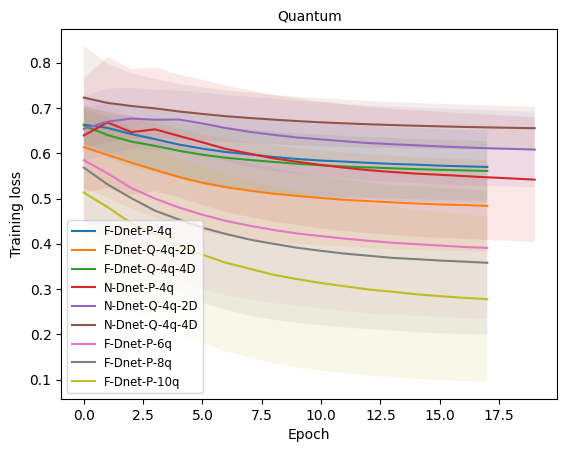

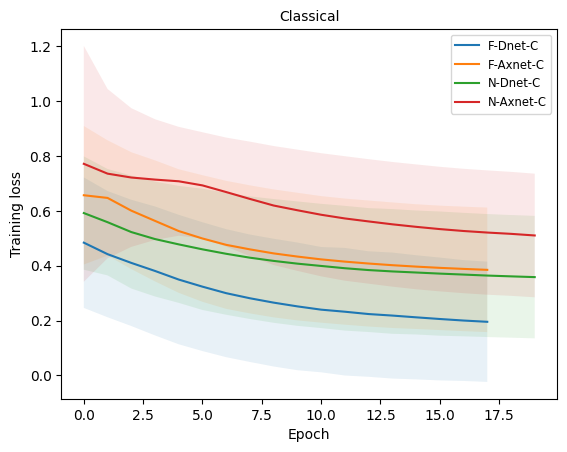

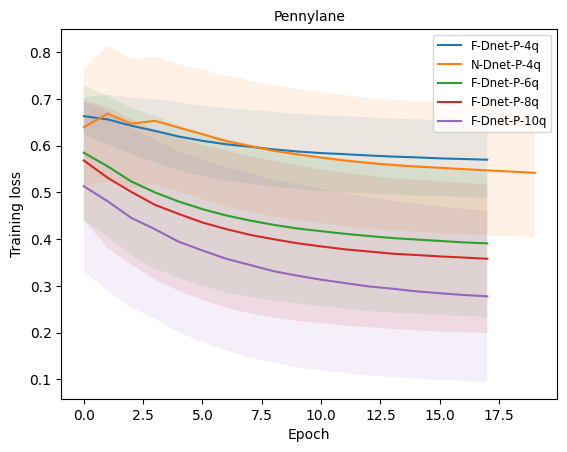

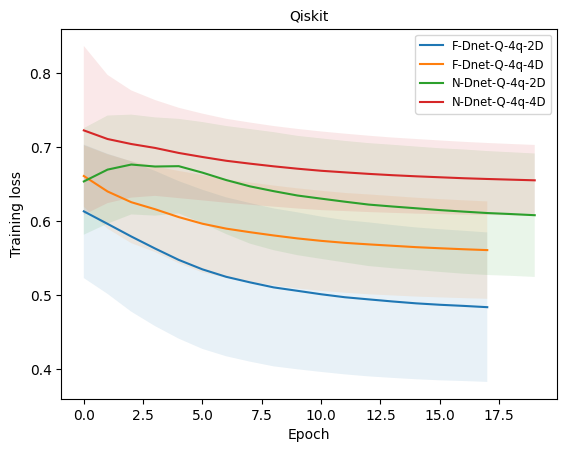

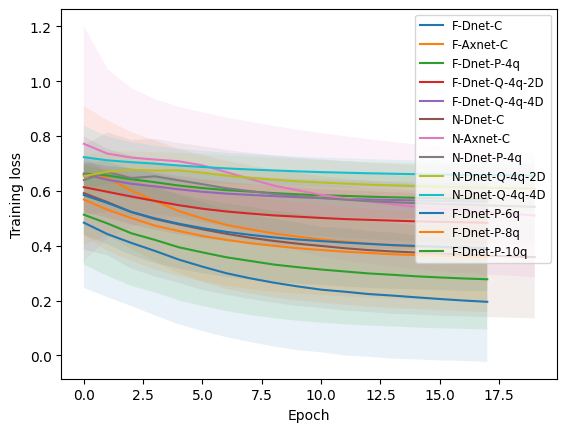

In [11]:
loss_dic = {
    "Quantum" : [2,3,4,7,8,9,10,11,12], 
    "Classical" : [0,1,5,6],
    "Pennylane" : [2,7,10,11,12],
    "Qiskit" : [3,4,8,9],
    }
for name,seq in loss_dic.items():
    loss_dic_graph = {}
    for num,(nm, df) in enumerate(all_loss_dic.items()):
        if num in seq:
            loss_dic_graph[nm] = df
    plt_loss(name,loss_dic_graph)
plt_loss(None, all_loss_dic)

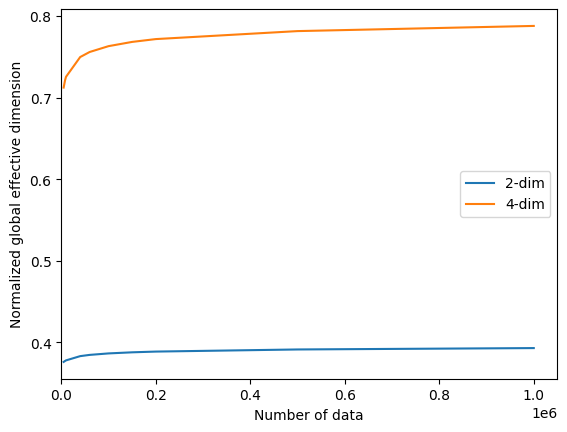

In [12]:
import matplotlib.pyplot as plt
import numpy as np
n = [5000, 8000, 10000, 40000, 60000, 100000, 150000, 200000, 500000, 1000000]
d=24
global_eff_dim_0 = [9.02850016, 9.05650995, 9.07356522, 9.19861889, 9.23507626, 9.27861731, 9.31093398, 9.33259925, 9.39477716, 9.43547134]
plt.plot(n, np.array(global_eff_dim_0) / d, label='2-dim')
global_eff_dim_1 = [17.09487015, 17.30959315, 17.41102108, 17.9927142,  18.1411092,  18.31300422, 18.43795941, 18.52080861, 18.75571317, 18.90792654]
plt.plot(n, np.array(global_eff_dim_1) / d, label='4-dim')
plt.xlabel("Number of data")
plt.ylabel("Normalized global effective dimension")
#plt.yticks([0, 0.5, 1])
plt.xlim(left=0)
#plt.xticks([-1, 40], [0,40])
plt.legend()
if save_result: plt.savefig(f"{result_OUT}/effective_dimension.png")
plt.show()